In [ ]:
!pip install xmltodict
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.4MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import keras

In [ ]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/MaskvsNoMask_Dataset'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names

In [ ]:
def get_path(image_name):
    
    home_path = '/content/drive/My Drive/Colab Notebooks/MaskvsNoMask_Dataset'
    image_path = home_path + '/images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
       
    label_path = home_path + '/labels/' + label_name
        
    return  image_path, label_path

In [ ]:
def parse_xml(label_path):
    
    
    
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size

In [ ]:
def visualize_image(image_name, bndbox=True):
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'bad':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [ ]:
image_names = getImageNames()

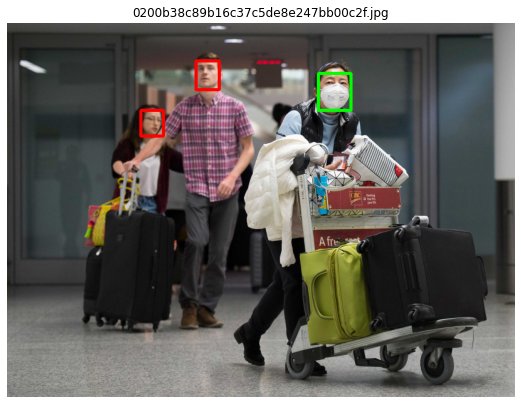

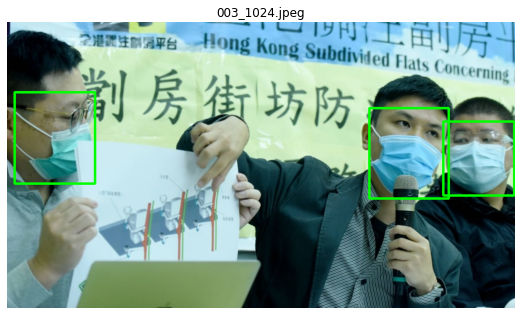

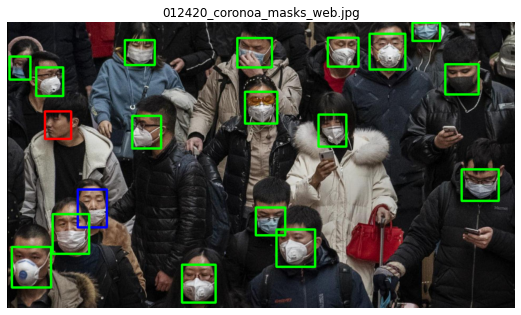

In [ ]:
NUM_OF_IMGS_TO_VISUALIZE = 3

for i in range(NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

In [ ]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "good":
            label_num = 0
        elif name == "bad":
            label_num = 1
        else:
            label_num = 2
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [ ]:
print(len(image_names))
print(type(image_names))
x = []
for image_name in image_names[0:400]:
  x.append(image_name)
print(len(x))

678
<class 'list'>
400


In [ ]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
#label_2_dir = dir_name + "2/"
models_dir = "models/"

dir_name1 = 'val/'
label_0_dir1 = dir_name1 + "0/"
label_1_dir1 = dir_name1 + "1/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
#createDirectory(label_2_dir)
createDirectory(dir_name1)
createDirectory(label_0_dir1)
createDirectory(label_1_dir1)
createDirectory(models_dir)

In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for image_name in image_names[0:500]:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
        #else:
            #croped_img_name = str(label_2_counter) + ".jpg"
            #cv2.imwrite(label_2_dir + croped_img_name, img)
            #label_2_counter += 1

In [ ]:
label_0_counter1 = 0
label_1_counter1 = 0
#label_2_counter = 0

for image_name in image_names[501:677]:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter1) + ".jpg"
            cv2.imwrite(label_0_dir1 + croped_img_name, img)
            label_0_counter1 += 1
        elif label == 1:
            croped_img_name = str(label_1_counter1) + ".jpg"
            cv2.imwrite(label_1_dir1 + croped_img_name, img)
            label_1_counter1 += 1

In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
filenames_label1_0 = [f for f in listdir(label_0_dir1) if isfile(join(label_0_dir1, f))]
filenames_label1_1 = [f for f in listdir(label_1_dir1) if isfile(join(label_1_dir1, f))]
#onlyfiles_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

In [ ]:
print("Total number of images in training set: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0 (train): " + str(len(filenames_label_0)))
print("Number of images labeled 1 (train): " + str(len(filenames_label_1)))

print("Total number of images in validation set: " + str(len(filenames_label1_0) + len(filenames_label1_1)))
print("Number of images labeled 0 (val): " + str(len(filenames_label1_0)))
print("Number of images labeled 1 (val): " + str(len(filenames_label1_1)))
#print("Number of images labeled 2: " + str(len(onlyfiles_2)))

Total number of images in training set: 2879
Number of images labeled 0 (train): 2376
Number of images labeled 1 (train): 503
Total number of images in validation set: 902
Number of images labeled 0 (val): 739
Number of images labeled 1 (val): 163


In [ ]:
import keras.models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout


In [ ]:
# ResNet50 Model in tensorflow

pre_trained_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3))
for layer in pre_trained_model.layers:
  layer.trainable=False

pre_trained_model.summary()


94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import layers
import os


x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(.2)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=Adam(lr=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/val'

train_mask_dir = os.path.join(train_dir, '0') 
train_non_mask_dir = os.path.join(train_dir, '1') 
validation_mask_dir = os.path.join(validation_dir, '0')
validation_non_mask_dir = os.path.join(validation_dir, '1')

train_mask_fnames = os.listdir(train_mask_dir)
train_non_mask_fnames = os.listdir(train_non_mask_dir)
validation_mask_fnames = os.listdir(validation_mask_dir)
validation_non_mask_fnames = os.listdir(validation_non_mask_dir)

print(len(train_mask_fnames))
print(len(train_non_mask_fnames))
print(len(validation_mask_fnames))
print(len(validation_non_mask_fnames))

2376
503
739
163


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    # rotation_range = 40,
    # width_shift_range = 0.2,
    # height_shift_range = 0.2,
    # shear_range = 0.2,
    # zoom_range = 0.2,
    # horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    # rescale = 1./255.
 )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(224,224)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
     validation_dir,
     batch_size=64,
     class_mode='binary',
     target_size=(224,224)
 )


Found 2879 images belonging to 2 classes.
Found 902 images belonging to 2 classes.


In [ ]:

history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
45/45 [==============================] - 29s 636ms/step - loss: 9.2989 - accuracy: 0.8982 - val_loss: 0.2673 - val_accuracy: 0.9645
Epoch 2/10
45/45 [==============================] - 26s 581ms/step - loss: 0.0834 - accuracy: 0.9812 - val_loss: 0.0615 - val_accuracy: 0.9845
Epoch 3/10
45/45 [==============================] - 26s 585ms/step - loss: 0.0257 - accuracy: 0.9927 - val_loss: 0.0621 - val_accuracy: 0.9823
Epoch 4/10
45/45 [==============================] - 26s 585ms/step - loss: 0.0101 - accuracy: 0.9976 - val_loss: 0.0779 - val_accuracy: 0.9834
Epoch 5/10
45/45 [==============================] - 26s 583ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0578 - val_accuracy: 0.9845
Epoch 6/10
45/45 [==============================] - 26s 585ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0509 - val_accuracy: 0.9867
Epoch 7/10
45/45 [==============================] - 26s 585ms/step

Text(0.5, 1.0, 'Training and validation loss')

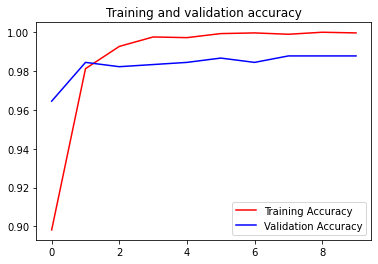

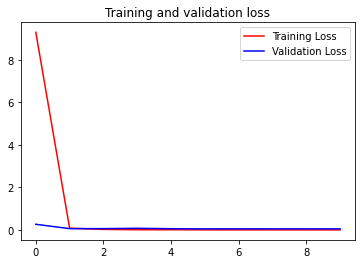

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend()

plt.title('Training and validation loss')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
fig=plt.figure()
    
y = fig.add_subplot(2,3,1)
#model_out = model.predict([data])[0]
img = cv2.imread('/content/3p7p0002870p18p3sqq3.jpg')
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

y_pred = model.predict(img)
print(y_pred)

if (y_pred > 0.5):
  y_pred = 1
else:
  y_pred = 0
  
model_out = y_pred
if model_out == 0:
  str_label='with mask'
else: str_label='without mask'
        
y.imshow(img.reshape(224,224,3))
plt.title(str_label)
y.axes.get_xaxis().set_visible(False)
y.axes.get_yaxis().set_visible(False)
plt.show()
print(model_out)